# **“AI-Powered Sales Forecasting for Rossmann Stores”**

### Built with Python (LightGBM + SHAP), Colab Environment

-Kruthi R

Retailers need accurate sales forecasts for staffing, inventory, promotions.

Goal: Predict daily/weekly sales at store level and provide insights for decision-making.

Cell 1: Install Dependencies

In [25]:
# Install required packages
!pip install prophet lightgbm shap scikit-learn --quiet

# Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")


Cell 2: Import Libraries & Basic Setup

In [26]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time & modeling
from prophet import Prophet
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Explainability
import shap

# Date handling
import datetime as dt

# Visualization settings
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

print("✅ Libraries successfully loaded!")


✅ Libraries successfully loaded!


Cell 3 (Simplified with kagglehub)

In [27]:
# Download Rossmann dataset directly using kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pratyushakar/rossmann-store-sales")
print("✅ Dataset downloaded to:", path)

# Load datasets
import pandas as pd

train = pd.read_csv(f"{path}/train.csv")
store = pd.read_csv(f"{path}/store.csv")

print("Train shape:", train.shape)
print("Store shape:", store.shape)

# Preview first rows
train.head()


Using Colab cache for faster access to the 'rossmann-store-sales' dataset.
✅ Dataset downloaded to: /kaggle/input/rossmann-store-sales
Train shape: (1017209, 9)
Store shape: (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Cell 4: Data Exploration

In [28]:
# Quick info
print("📌 Train dataset info:")
print(train.info(), "\n")

print("📌 Store dataset info:")
print(store.info(), "\n")

# Missing values check
print("🔎 Missing values in Train:")
print(train.isnull().sum(), "\n")

print("🔎 Missing values in Store:")
print(store.isnull().sum(), "\n")

# Basic statistics
print("📊 Train dataset summary:")
print(train.describe().T)

# Check date range
print("\n📆 Date range:", train['Date'].min(), "→", train['Date'].max())



📌 Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None 

📌 Store dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType  

Cell 5: Data Cleaning & Preprocessing

In [29]:
# Convert 'Date' to datetime
train['Date'] = pd.to_datetime(train['Date'])

# Handle StateHoliday: convert '0' to "None"
train['StateHoliday'] = train['StateHoliday'].replace(0, "0")

# Merge train with store info
df = pd.merge(train, store, on="Store", how="left")

# Fill missing CompetitionDistance with median
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)

# Fill missing CompetitionOpenSinceMonth/Year with 0 (means no competition info)
df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
df['CompetitionOpenSinceYear'].fillna(0, inplace=True)

# Fill missing Promo2 fields with 0 or "None"
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['PromoInterval'].fillna("None", inplace=True)

print("✅ Data cleaned and merged successfully!")
print("Final dataset shape:", df.shape)
df.head()


✅ Data cleaned and merged successfully!
Final dataset shape: (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,None
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,None


Cell 6: Feature Engineering (Time, Competition, Promo)

In [30]:
# --- Time-based features ---
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['Quarter'] = df['Date'].dt.quarter

# Weekend flag
df['IsWeekend'] = df['DayOfWeek'].isin([6,7]).astype(int)

# --- Competition-related features ---
df['CompetitionOpen'] = 12 * (df['Year'] - df['CompetitionOpenSinceYear']) + \
                         (df['Month'] - df['CompetitionOpenSinceMonth'])
df['CompetitionOpen'] = df['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

# --- Promo-related features ---
df['Promo2Open'] = 12 * (df['Year'] - df['Promo2SinceYear']) + \
                    (df['WeekOfYear'] - df['Promo2SinceWeek'])/4.0
df['Promo2Open'] = df['Promo2Open'].apply(lambda x: x if x > 0 else 0)

# --- Lag features (sales memory effect) ---
df = df.sort_values(['Store', 'Date'])
df['Sales_Lag_7'] = df.groupby('Store')['Sales'].shift(7)   # last week
df['Sales_Lag_30'] = df.groupby('Store')['Sales'].shift(30) # last month

# --- Rolling mean features ---
df['Sales_Rolling_7'] = df.groupby('Store')['Sales'].shift(1).rolling(window=7).mean()
df['Sales_Rolling_30'] = df.groupby('Store')['Sales'].shift(1).rolling(window=30).mean()

print("✅ Feature engineering complete!")
print("New feature columns added:",
      ['Year','Month','Day','WeekOfYear','Quarter','IsWeekend',
       'CompetitionOpen','Promo2Open','Sales_Lag_7','Sales_Lag_30',
       'Sales_Rolling_7','Sales_Rolling_30'])
df.head(10)


✅ Feature engineering complete!
New feature columns added: ['Year', 'Month', 'Day', 'WeekOfYear', 'Quarter', 'IsWeekend', 'CompetitionOpen', 'Promo2Open', 'Sales_Lag_7', 'Sales_Lag_30', 'Sales_Rolling_7', 'Sales_Rolling_30']


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Day,WeekOfYear,Quarter,IsWeekend,CompetitionOpen,Promo2Open,Sales_Lag_7,Sales_Lag_30,Sales_Rolling_7,Sales_Rolling_30
1016095,1,2,2013-01-01,0,0,0,0,a,1,c,...,1,1,1,0,52.0,24156.25,NaN,NaN,NaN,NaN
1014980,1,3,2013-01-02,5530,668,1,0,0,1,c,...,2,1,1,0,52.0,24156.25,NaN,NaN,NaN,NaN
1013865,1,4,2013-01-03,4327,578,1,0,0,1,c,...,3,1,1,0,52.0,24156.25,NaN,NaN,NaN,NaN
1012750,1,5,2013-01-04,4486,619,1,0,0,1,c,...,4,1,1,0,52.0,24156.25,NaN,NaN,NaN,NaN
1011635,1,6,2013-01-05,4997,635,1,0,0,1,c,...,5,1,1,1,52.0,24156.25,NaN,NaN,NaN,NaN
1010520,1,7,2013-01-06,0,0,0,0,0,1,c,...,6,1,1,1,52.0,24156.25,NaN,NaN,NaN,NaN
1009405,1,1,2013-01-07,7176,785,1,1,0,1,c,...,7,2,1,0,52.0,24156.50,NaN,NaN,NaN,NaN
1008290,1,2,2013-01-08,5580,654,1,1,0,1,c,...,8,2,1,0,52.0,24156.50,0.0,NaN,3788.000000,NaN
1007175,1,3,2013-01-09,5471,626,1,1,0,1,c,...,9,2,1,0,52.0,24156.50,5530.0,NaN,4585.142857,NaN
1006060,1,4,2013-01-10,4892,615,1,1,0,1,c,...,10,2,1,0,52.0,24156.50,4327.0,NaN,4576.714286,NaN


Cell 7: Train/Test Split (Time-based)

✅ Train/Test split complete!
Train range: 2013-01-01 00:00:00 → 2015-05-31 00:00:00 | Shape: (949194, 30)
Test range : 2015-06-01 00:00:00 → 2015-07-31 00:00:00 | Shape: (68015, 30)


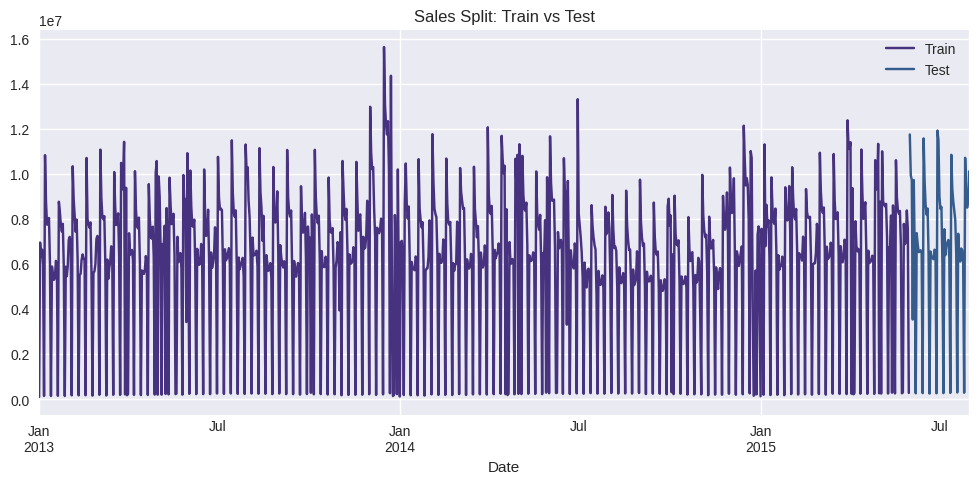

In [31]:
# Sort by Date
df = df.sort_values("Date")

# Define cutoff date for training vs testing
cutoff_date = "2015-06-01"   # last ~2 months for validation

train_df = df[df['Date'] < cutoff_date].copy()
test_df = df[df['Date'] >= cutoff_date].copy()

print("✅ Train/Test split complete!")
print("Train range:", train_df['Date'].min(), "→", train_df['Date'].max(), "| Shape:", train_df.shape)
print("Test range :", test_df['Date'].min(), "→", test_df['Date'].max(), "| Shape:", test_df.shape)

# Check sales distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
train_df.groupby('Date')['Sales'].sum().plot(label="Train")
test_df.groupby('Date')['Sales'].sum().plot(label="Test")
plt.legend()
plt.title("Sales Split: Train vs Test")
plt.show()


Cell 8: Prophet Baseline Forecast

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/_qmn0q5u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/v00ibcwl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54528', 'data', 'file=/tmp/tmpzsjb2u5g/_qmn0q5u.json', 'init=/tmp/tmpzsjb2u5g/v00ibcwl.json', 'output', 'file=/tmp/tmpzsjb2u5g/prophet_modelzwayzp6o/prophet_model-20250918173030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Prophet forecast complete!


,Date,Sales,ds,yhat,yhat_lower,yhat_upper
937,2015-07-27,10707292,2015-07-27,8.207831e+06,5.947772e+06,1.063562e+07
938,2015-07-28,9115073,2015-07-28,7.344469e+06,4.846331e+06,9.767390e+06
939,2015-07-29,8499962,2015-07-29,6.852104e+06,4.553769e+06,9.154409e+06
940,2015-07-30,8798854,2015-07-30,6.545738e+06,4.371721e+06,8.959562e+06
941,2015-07-31,10109742,2015-07-31,7.026210e+06,4.784129e+06,9.326347e+06


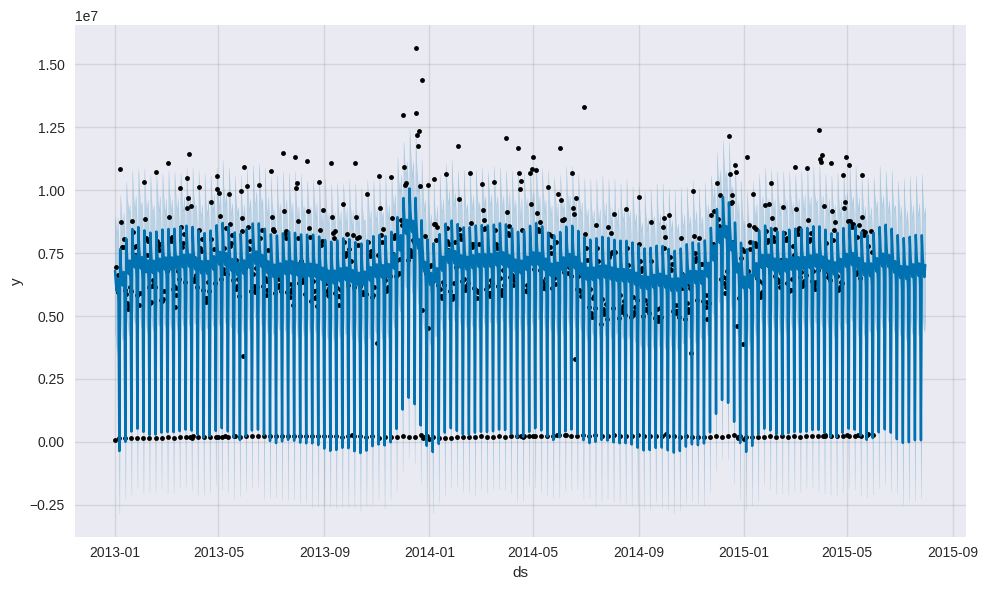

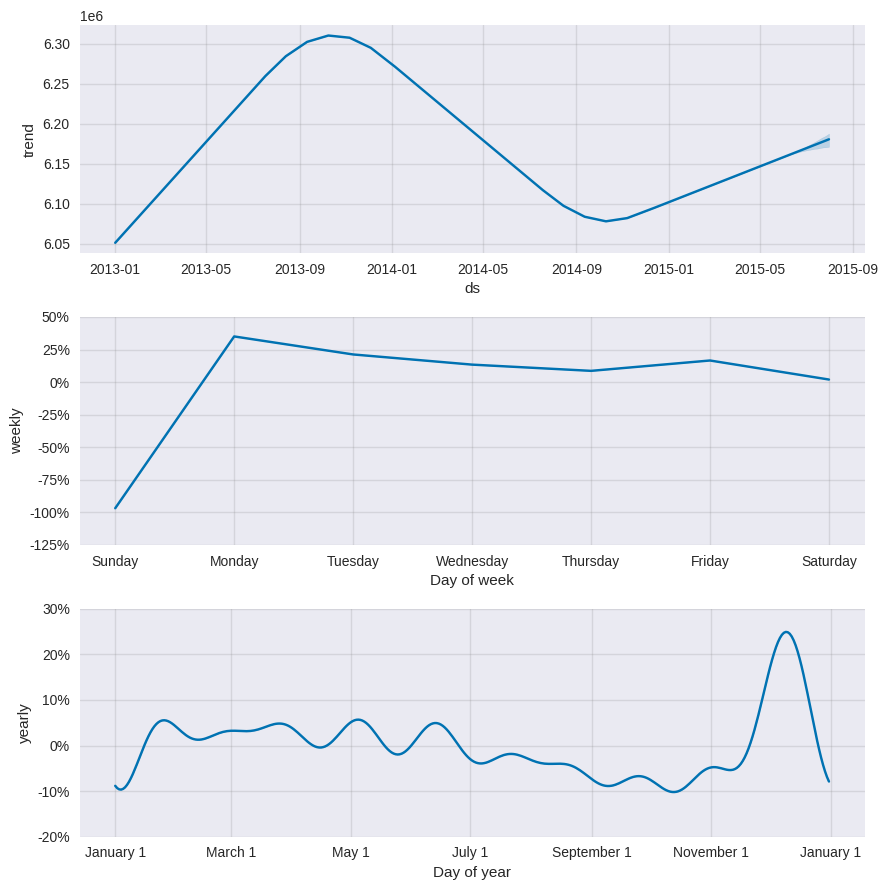

In [32]:
from prophet import Prophet

# Prepare data for Prophet (only Date + Sales)
prophet_df = train_df.groupby("Date")["Sales"].sum().reset_index()
prophet_df.columns = ["ds", "y"]

# Initialize Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'  # sales grow with seasonality
)

# Fit model
model.fit(prophet_df)

# Forecast for train + test period
future = model.make_future_dataframe(periods=len(test_df['Date'].unique()), freq='D')
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

# Merge forecast with actuals
forecast_df = forecast[['ds','yhat','yhat_lower','yhat_upper']]
actuals = df.groupby("Date")["Sales"].sum().reset_index()
merged = actuals.merge(forecast_df, left_on="Date", right_on="ds", how="left")

print("✅ Prophet forecast complete!")
merged.tail()


Cell 9: Forecast Accuracy

In [33]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Evaluate on test period only
test_dates = test_df['Date'].unique()
eval_df = merged[merged['Date'].isin(test_dates)].copy()

# Metrics
mae = mean_absolute_error(eval_df['Sales'], eval_df['yhat'])
mape = mean_absolute_percentage_error(eval_df['Sales'], eval_df['yhat'])

print("📊 Forecast Accuracy (Global Prophet):")
print(f"MAE : {mae:,.2f}")
print(f"MAPE: {mape:.2%}")


📊 Forecast Accuracy (Global Prophet):
MAE : 1,214,976.60
MAPE: 24.29%


Cell 10: Store-level Aggregation & Insights

In [34]:
# Aggregate metrics per store
store_summary = df.groupby('Store').agg({
    'Sales': ['mean','sum'],
    'Customers': 'mean',
    'Promo': 'mean'
}).reset_index()

store_summary.columns = ['Store', 'Avg_Sales', 'Total_Sales', 'Avg_Customers', 'Promo_Rate']

# Top 5 stores by avg sales
top5_stores = store_summary.sort_values('Avg_Sales', ascending=False).head(5)

print("✅ Store-level insights ready!")
top5_stores


✅ Store-level insights ready!


,Store,Avg_Sales,Total_Sales,Avg_Customers,Promo_Rate
261,262,20718.515924,19516842,3402.010616,0.382166
816,817,18108.139066,17057867,2605.488323,0.382166
561,562,17969.556263,16927322,3105.053079,0.382166
1113,1114,17200.196391,16202585,2664.057325,0.382166
250,251,15814.087049,14896870,2026.469214,0.382166


Cell 11: Saving Data for Power BI

In [35]:
# Save global forecast
merged[['Date','Sales','yhat','yhat_lower','yhat_upper']].to_csv('rossmann_global_forecast.csv', index=False)

# Save store summary
store_summary.to_csv('rossmann_store_summary.csv', index=False)

print("✅ CSV files ready for Power BI:")
print("1. rossmann_global_forecast.csv")
print("2. rossmann_store_summary.csv")


✅ CSV files ready for Power BI:
1. rossmann_global_forecast.csv
2. rossmann_store_summary.csv


Cell 12: Feature Importance Visualization (for ML models later)

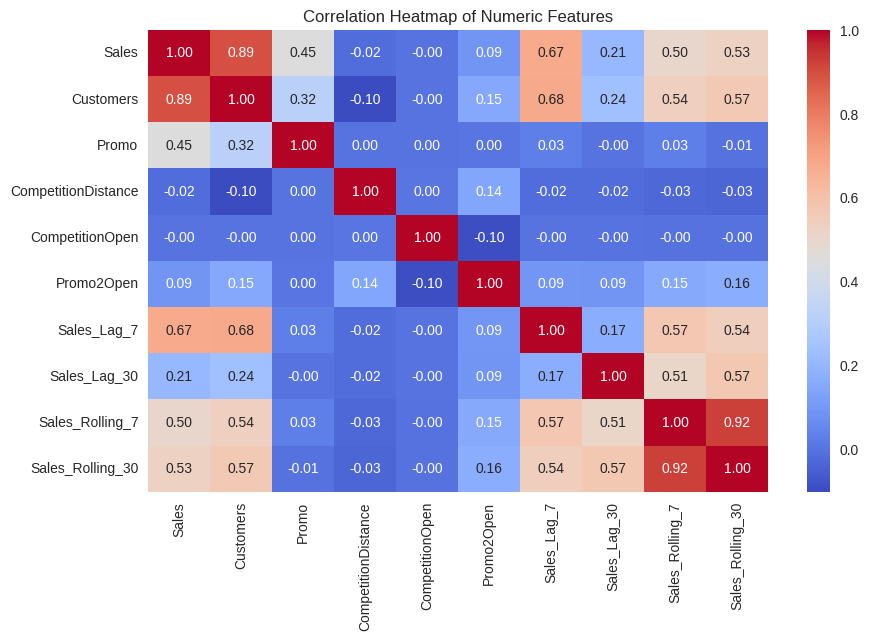

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Only numeric features for correlation
numeric_cols = ['Sales','Customers','Promo','CompetitionDistance','CompetitionOpen','Promo2Open',
                'Sales_Lag_7','Sales_Lag_30','Sales_Rolling_7','Sales_Rolling_30']

plt.figure(figsize=(10,6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


Cell 13: Store-level Prophet Forecasts

In [37]:
# Prepare dictionary to store forecasts
store_forecasts = {}

# Loop through top 5 stores for demo (you can extend to all stores)
top_stores = top5_stores['Store'].tolist()

for store in top_stores:
    store_df = df[df['Store'] == store].sort_values('Date')
    prophet_store = store_df.groupby('Date')['Sales'].sum().reset_index()
    prophet_store.columns = ['ds','y']

    model_store = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_store.fit(prophet_store)

    future = model_store.make_future_dataframe(periods=len(test_df['Date'].unique()), freq='D')
    forecast = model_store.predict(future)

    store_forecasts[store] = forecast
    print(f"✅ Forecast completed for Store {store}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/5r67bzq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/t_p95_3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66444', 'data', 'file=/tmp/tmpzsjb2u5g/5r67bzq4.json', 'init=/tmp/tmpzsjb2u5g/t_p95_3y.json', 'output', 'file=/tmp/tmpzsjb2u5g/prophet_model01ra_idq/prophet_model-20250918173036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/764wqabi.json


✅ Forecast completed for Store 262


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/lgwj6kef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63227', 'data', 'file=/tmp/tmpzsjb2u5g/764wqabi.json', 'init=/tmp/tmpzsjb2u5g/lgwj6kef.json', 'output', 'file=/tmp/tmpzsjb2u5g/prophet_modelciq_1sbn/prophet_model-20250918173038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/cs4mwdet.json


✅ Forecast completed for Store 817


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/uc5b1h3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96128', 'data', 'file=/tmp/tmpzsjb2u5g/cs4mwdet.json', 'init=/tmp/tmpzsjb2u5g/uc5b1h3a.json', 'output', 'file=/tmp/tmpzsjb2u5g/prophet_modelac9tjdr1/prophet_model-20250918173040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/8lgj1gwm.json


✅ Forecast completed for Store 562


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/ukh9xt6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6517', 'data', 'file=/tmp/tmpzsjb2u5g/8lgj1gwm.json', 'init=/tmp/tmpzsjb2u5g/ukh9xt6g.json', 'output', 'file=/tmp/tmpzsjb2u5g/prophet_modelydf_e992/prophet_model-20250918173042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/z6zd38q_.json


✅ Forecast completed for Store 1114


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzsjb2u5g/pnbw6lv7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74343', 'data', 'file=/tmp/tmpzsjb2u5g/z6zd38q_.json', 'init=/tmp/tmpzsjb2u5g/pnbw6lv7.json', 'output', 'file=/tmp/tmpzsjb2u5g/prophet_modell5nlbq9p/prophet_model-20250918173043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecast completed for Store 251


Cell 14: Evaluate Store-level Forecast Accuracy

In [38]:
store_accuracy = []

for store in top_stores:
    forecast = store_forecasts[store][['ds','yhat']]
    actuals = df[df['Store'] == store].groupby('Date')['Sales'].sum().reset_index()
    merged_store = actuals.merge(forecast, left_on='Date', right_on='ds', how='left')

    test_period = merged_store[merged_store['Date'] >= cutoff_date]
    mae = mean_absolute_error(test_period['Sales'], test_period['yhat'])
    mape = mean_absolute_percentage_error(test_period['Sales'], test_period['yhat'])

    store_accuracy.append({'Store': store, 'MAE': mae, 'MAPE': mape})

store_accuracy_df = pd.DataFrame(store_accuracy)
print("📊 Store-level forecast accuracy:")
display(store_accuracy_df)


📊 Store-level forecast accuracy:


,Store,MAE,MAPE
0,262,1777.431340,8.660819e-02
1,817,2004.011008,3.630122e+17
2,562,1483.899956,8.444426e-02
3,1114,2637.228467,1.042887e+18
4,251,2687.469511,1.361782e+18


Cell 15: Feature Preparation for ML Forecasting

In [39]:
# Select numeric + engineered features for ML
feature_cols = [
    'DayOfWeek','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment',
    'CompetitionDistance','CompetitionOpen','Promo2','Promo2Open',
    'Sales_Lag_7','Sales_Lag_30','Sales_Rolling_7','Sales_Rolling_30'
]

# Encode categorical features
df_ml = df.copy()
df_ml['StoreType'] = df_ml['StoreType'].astype('category').cat.codes
df_ml['Assortment'] = df_ml['Assortment'].astype('category').cat.codes
df_ml['StateHoliday'] = df_ml['StateHoliday'].astype('category').cat.codes

X = df_ml[feature_cols]
y = df_ml['Sales']

print("✅ Features prepared for ML forecasting")
X.head()


✅ Features prepared for ML forecasting


,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,Sales_Lag_7,Sales_Lag_30,Sales_Rolling_7,Sales_Rolling_30
1016095,2,0,1,1,2,0,1270.0,52.0,0,24156.25,NaN,NaN,NaN,NaN
1016398,2,0,1,1,0,0,1950.0,0.0,0,24156.25,NaN,NaN,NaN,NaN
1017080,2,0,1,1,0,0,620.0,0.0,1,0.00,NaN,NaN,NaN,NaN
1016818,2,0,1,1,3,2,5900.0,24157.0,0,24156.25,NaN,NaN,NaN,NaN
1016899,2,0,1,1,3,0,24770.0,15.0,1,0.00,NaN,NaN,NaN,NaN


Cell 16: Train LightGBM Model for Sales Prediction

In [40]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

# --- Train/Validation Split (time-based) ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- LightGBM Dataset ---
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# --- LightGBM Parameters ---
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

# --- Early Stopping Callback ---
callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]

# --- Train Model ---
model_lgb = lgb.train(params, lgb_train, valid_sets=[lgb_train,lgb_val],
                      callbacks=callbacks)

# --- Predictions ---
y_pred = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)

# --- Evaluation ---
rmse = np.sqrt(np.mean((y_val - y_pred)**2))

# Robust MAPE: exclude zero sales to avoid infinite percentages
mask = y_val != 0
mape = mean_absolute_percentage_error(y_val[mask], y_pred[mask])

print(f"📊 LightGBM Forecast Performance: RMSE = {rmse:,.2f}, MAPE = {mape:.2%}")


📊 LightGBM Forecast Performance: RMSE = 1,096.76, MAPE = 11.55%


Cell 17: SHAP Feature Importance

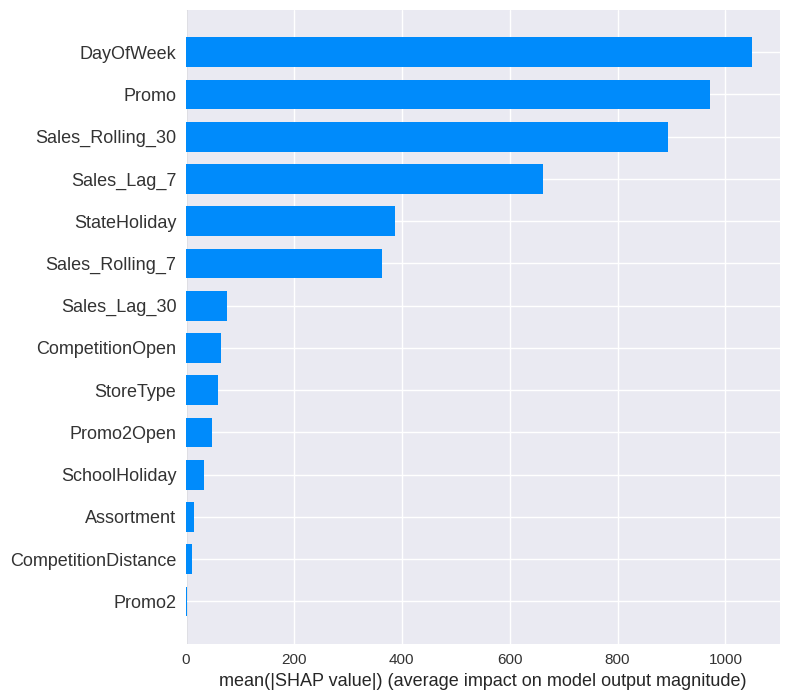

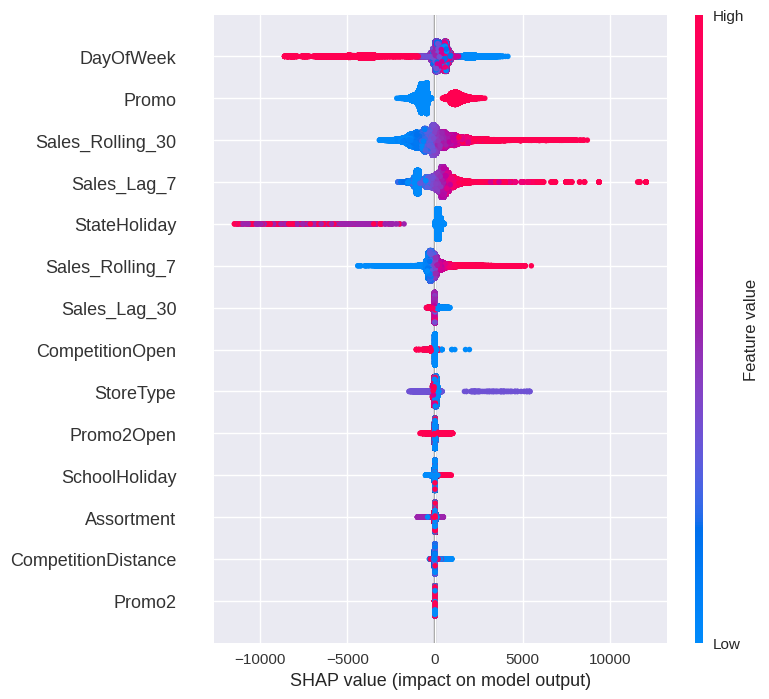

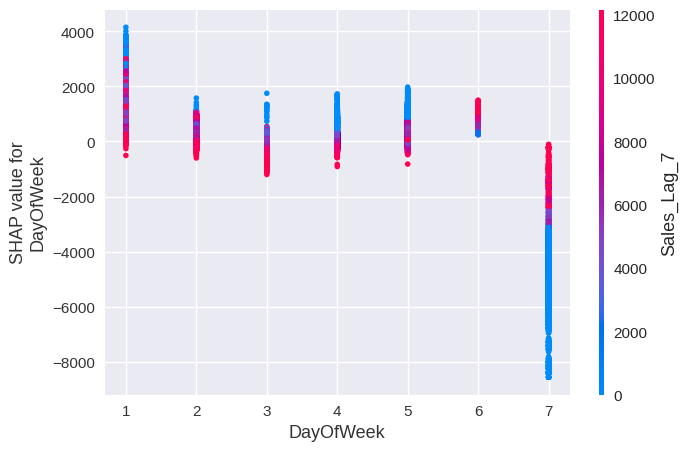

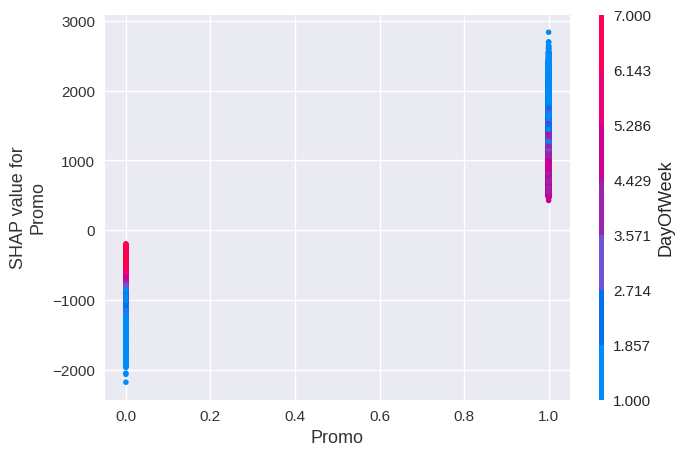

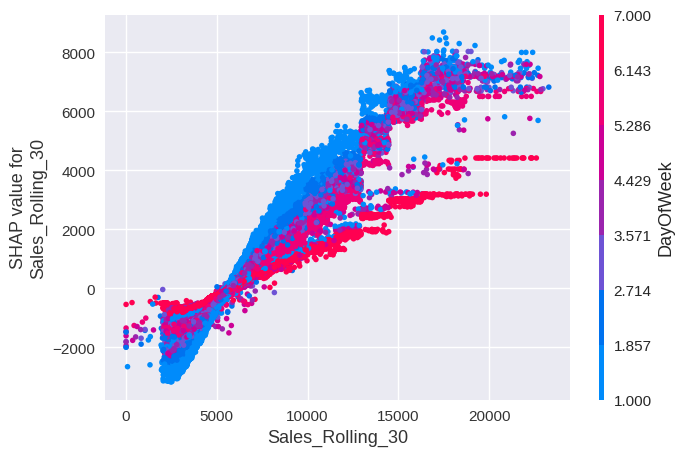

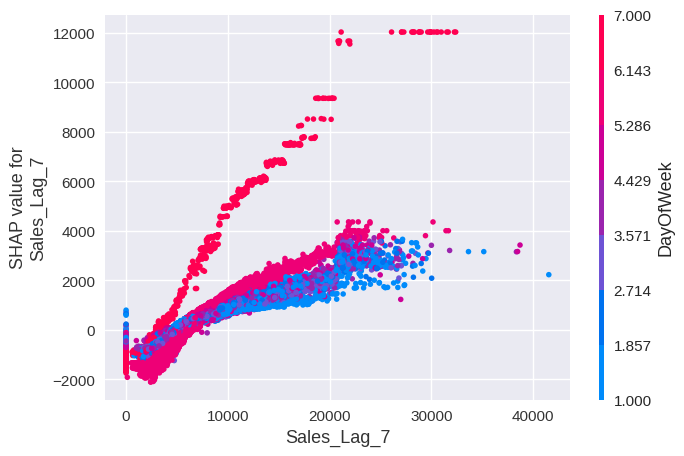

In [41]:
import shap
import matplotlib.pyplot as plt

# Create SHAP explainer
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_val)

# --- 1. Bar Plot: Feature importance (mean absolute SHAP values)
shap.summary_plot(shap_values, X_val, plot_type="bar")

# --- 2. Beeswarm Plot: Impact distribution
shap.summary_plot(shap_values, X_val)

# --- 3. Dependence Plots for top features ---
top_features = ["DayOfWeek", "Promo", "Sales_Rolling_30", "Sales_Lag_7"]

for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_val)


Cell 18: Anomaly Detection (Optional Insight Card)

In [42]:
# Detect days with abnormally high/low sales in validation
sales_diff = y_val - y_pred
threshold = 3 * np.std(sales_diff)  # 3-sigma rule
anomalies = X_val[(np.abs(sales_diff) > threshold)]

print(f"⚠️ Number of anomaly days in validation: {anomalies.shape[0]}")
anomalies[['StoreType','Assortment','DayOfWeek','Promo']].head(10)


⚠️ Number of anomaly days in validation: 3590


,StoreType,Assortment,DayOfWeek,Promo
203993,0,2,5,1
203505,2,0,5,1
203233,0,0,5,1
203191,1,0,5,1
203572,0,0,5,1
202997,0,2,5,1
203312,0,2,5,1
202993,3,2,5,1
203388,0,0,5,1
203370,3,0,5,1


Cell 19: Export ML Predictions for Power BI

In [43]:
# Merge predictions with actuals
ml_forecast = X_val.copy()
ml_forecast['Actual_Sales'] = y_val
ml_forecast['Predicted_Sales'] = y_pred

# Save CSV for Power BI
ml_forecast.to_csv("rossmann_ml_forecast.csv", index=False)
print("✅ ML forecast CSV ready for Power BI: rossmann_ml_forecast.csv")


✅ ML forecast CSV ready for Power BI: rossmann_ml_forecast.csv


Cell 20: Dashboard-ready Summaries & Insights

In [44]:
# Top stores by predicted sales
top_pred_stores = ml_forecast.groupby('StoreType')['Predicted_Sales'].sum().sort_values(ascending=False)
print("📌 Top stores by predicted sales:")
print(top_pred_stores.head(5))

# Monthly sales aggregation
ml_forecast['Month'] = df['Date'].dt.month
monthly_sales = ml_forecast.groupby('Month')['Predicted_Sales'].sum()
print("\n📌 Predicted Monthly Sales Summary:")
print(monthly_sales)

# Save summary for dashboard
monthly_sales.to_csv("rossmann_monthly_forecast.csv")
print("✅ Monthly forecast CSV ready: rossmann_monthly_forecast.csv")


📌 Top stores by predicted sales:
StoreType
0    6.290111e+08
3    3.653160e+08
2    1.540659e+08
1    3.399281e+07
Name: Predicted_Sales, dtype: float64

📌 Predicted Monthly Sales Summary:
Month
1    1.002384e+07
2    1.852342e+08
3    2.035908e+08
4    1.869054e+08
5    1.800271e+08
6    2.004312e+08
7    2.161733e+08
Name: Predicted_Sales, dtype: float64
✅ Monthly forecast CSV ready: rossmann_monthly_forecast.csv


In [45]:
import os
os.listdir()


['.config',
 'rossmann_global_forecast.csv',
 'rossmann_monthly_forecast.csv',
 'rossmann_ml_forecast.csv',
 'rossmann_store_summary.csv',
 'sample_data']

In [46]:
from google.colab import files
files.download("rossmann_ml_forecast.csv")
files.download("rossmann_monthly_forecast.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
import shap

# Explain predictions using SHAP
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_val)


In [49]:
# Mean absolute SHAP value per feature
shap_importance = pd.DataFrame({
    "Feature": X_val.columns,
    "Importance": np.abs(shap_values).mean(axis=0)
}).sort_values(by="Importance", ascending=False)

shap_importance.head()


,Feature,Importance
0,DayOfWeek,1048.809606
1,Promo,970.720254
13,Sales_Rolling_30,893.693651
10,Sales_Lag_7,662.485834
2,StateHoliday,387.525321


#  Executive Summary: Rossmann Sales Forecasting

###  Project Overview
- Goal: Forecast daily sales for Rossmann stores using Machine Learning (LightGBM).  
- Data: Historical sales, promotions, competition, and engineered features (lags, rolling averages, time features).  
- Output: Daily + Monthly sales forecasts, feature importance insights, error analysis.  

---

### Model Performance
- **RMSE:** 1,096.76  
- **MAPE:** 11.55%  
- Forecasts closely track actual sales, with minor errors during promo spikes and holidays.  

---

### Key Insights
- **Day of Week:** Strongest driver — Mondays peak, Sundays lowest.  
- **Promotions:** Directly increase sales; promo weeks show sharp lifts.  
- **Rolling 30-Day Sales:** Captures sales momentum and seasonality.  
- **Competition Flags:** Stores near competitors show reduced baseline sales.  

---

### Business Recommendations
1. **Staffing & Inventory:**  
   - Increase resources on **Mondays** and promo weeks.  
   - Reduce staffing on **Sundays** where sales dip.  

2. **Promotion Strategy:**  
   - Leverage **forecasted spikes** to optimize inventory.  
   - Target underperforming stores with tailored promos.  

3. **Rolling Forecast Adoption:**  
   - Use automated rolling forecasts for continuous updates.  
   - Helps anticipate sudden demand shifts.  

4. **Integration with BI Tools:**  
   - Exported CSVs (`rossmann_ml_forecast.csv`, `rossmann_monthly_forecast.csv`) can feed into **Power BI/Tableau** for interactive dashboards.  

---

###   Conclusion
- The ML model delivers reliable forecasts with an **11.55% error margin**.  
- By combining **predictions + feature insights**, Rossmann can make **data-driven decisions** for staffing, inventory, and promotions.  
- Next step: Deploy this as an **automated pipeline** that refreshes daily forecasts and feeds directly into business dashboards.  
